<a href="https://colab.research.google.com/github/sebassonse/startup_test/blob/main/kinda_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт и важные глобальные переменные

In [163]:
import pandas as pd
import bs4
import requests
import numpy as np
import seaborn
import matplotlib.pyplot as plt


In [164]:
url = 'https://www.forex-ratings.com'
url2 = "https://www.forex-ratings.com/forex-account/"
url3 = 'https://www.forex-ratings.com/forex-brokers/'

# Парсинг и преобразование

In [165]:
def parsing_n_prepare(url):
  raw_df = pd.read_html(url, flavor="bs4")
  raw_df = raw_df[0]

  useless_columns = ['#', 'Unnamed: 1', 'Reviews']
  df = raw_df.drop(useless_columns, axis=1)

  df.rename(columns={'Forex Broker':'Broker'}, inplace=True)

  account = df.Account.to_numpy()
  for id in range(len(account)):
    account[id] = int(account[id][1:])
  
  df.Account = pd.DataFrame({'Account':account})

  return df


def get_year_n_status(url3):
  raw_df = pd.read_html(url3, flavor="bs4")[0]

  useless_columns = ['#', 'Unnamed: 1', 'Regulation', 'Reviews']
  raw_df = raw_df.drop(useless_columns, axis=1)
  raw_df.rename(columns={'Forex Broker':'Broker'}, inplace=True)

  status = raw_df.Status.to_numpy()

  for id in range(len(status)):
    if str(status[id]) == 'nan':
       status[id] = 'Regular'
  
  raw_df = raw_df.replace(raw_df.Status, pd.DataFrame({'Status':[status]}))

  return raw_df

def merge_dataframes(main, status_n_year):
  merged = pd.merge(main, status_n_year, how='inner', on='Broker', suffixes=('_old', ''))
  merged = merged.drop('Status_old', axis=1)
  merged = merged.drop_duplicates(subset='Broker', ignore_index=True)
  merged.Year = merged.Year.astype(np.int64)
  return(merged)

def set_reg_count(df):
  reg_count = []
  regulations = df.Regulation.to_numpy()

  for id in range(len(df)):
    if str(regulations[id]) != 'nan':
      l = len(str(regulations[id]).split(', '))
    else:
      l = 0
    
    reg_count.append(l)

  df = pd.concat((df, pd.DataFrame({'reg_cnt':reg_count})), axis=1)

  return df

In [166]:
main_df = parsing_n_prepare(url)
year_n_data_df = get_year_n_status(url3)

df = merge_dataframes(main_df, year_n_data_df)

full_df = set_reg_count(df)

In [167]:
full_df.head()

,Broker,For,Against,Type,Regulation,Leverage,Account,Advisors,Year,Status,reg_cnt
0,FXTM,95%,5%,"Broker, ECN","CySEC, FCA, IFSC",1000,100,"Flex, 1000pip Climber",2011,Recommended,3
1,OctaFX,94%,6%,Broker,SVG,500,50,"WallStreet Evolution 2.0, Learn2Trade",2011,Regular,1
2,XM,93%,7%,Broker,"ASIC, CySEC, FSC",1000,5,"FX Classic Trader, Odin Forex Robot",2009,Recommended,3
3,FXCC,92%,8%,"ECN, STP","CySEC, SVG",500,1,"Forex Truck, Forex Fury",2010,Recommended,2
4,FxPro,91%,9%,"Broker, NDD","CySEC, FCA, FSCA, SCB",500,100,"Forex Gump, Earth Robot",2006,Recommended,4


# Отвечаем на интересные вопросы

### Какой самый частый тип регуляции (regulation)?


In [168]:
regulation_col = main_df.Regulation.to_numpy()
reg_count = dict()

for row in regulation_col:
  names = list(str(row).split(', '))
  for name in names:
    if name not in reg_count.keys():
      reg_count[name] = 1
    reg_count[name] += 1

nan_count = reg_count.pop('nan')


reg_list = sorted([[count, name] for name, count in reg_count.items()], reverse=True)


print(f'Три самых частых типа регуляции:\n\
 \n{reg_list[0][1]} (используют {reg_list[0][0]*100/42:.3}% брокеров),\
 \n{reg_list[1][1]} (используют {reg_list[1][0]*100/42:.3}% брокеров),\
 \n{reg_list[2][1]} (используют {reg_list[2][0]*100/42:.3}% брокеров)\n')

print(f'При этом {nan_count*100/43:.3}% брокеров не используют регуляцию вообще (или она не указана)')

Три самых частых типа регуляции:
 
CySEC (используют 23.8% брокеров), 
FCA (используют 19.0% брокеров), 
FSCA (используют 14.3% брокеров)

При этом 44.2% брокеров не используют регуляцию вообще (или она не указана)


---
---

### Зависит ли то, рекомендует данная площадка брокера или нет, от следующих факторов: длительность существования брокера, количество регуляций (лицензий), размер плеча (leverage)

#### Зависимость от длительности существования

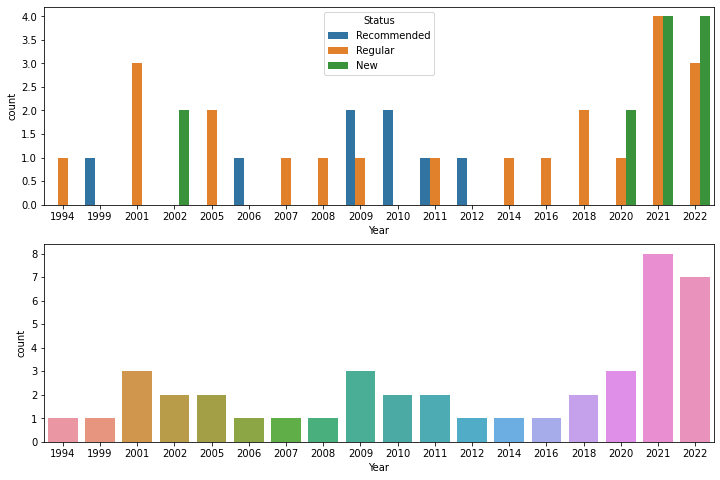

In [169]:
plt.figure(figsize=(12, 8))

plt.subplot((211))
f = seaborn.countplot(data=full_df, x="Year", hue="Status")

plt.subplot((212))
f = seaborn.countplot(data=full_df, x="Year")

По данной гистограмме можно наблюдать, что площадка рекомендует в основном не очень молодых брокеров

---

#### Зависимость от количества регуляций

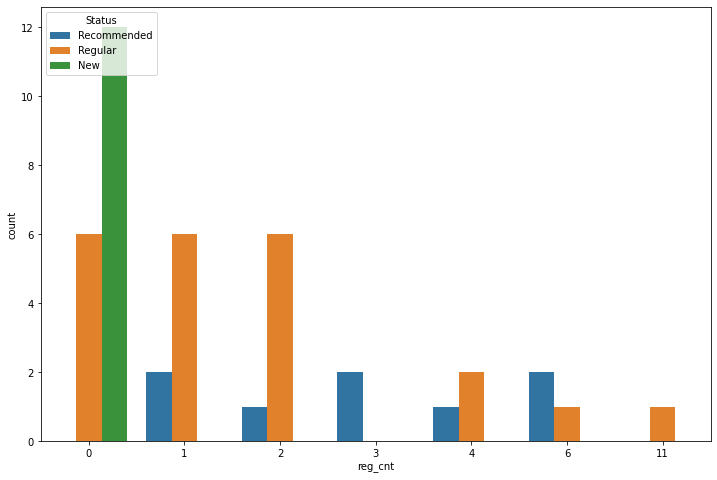

In [170]:
plt.figure(figsize=(12, 8))

f = seaborn.countplot(data=full_df, x='reg_cnt', hue='Status')


Судя по всему, готовность площадки рекомендовать брокера никак не зависит от количества регуляций: главное, чтобы они просто были, хотя бы одна.

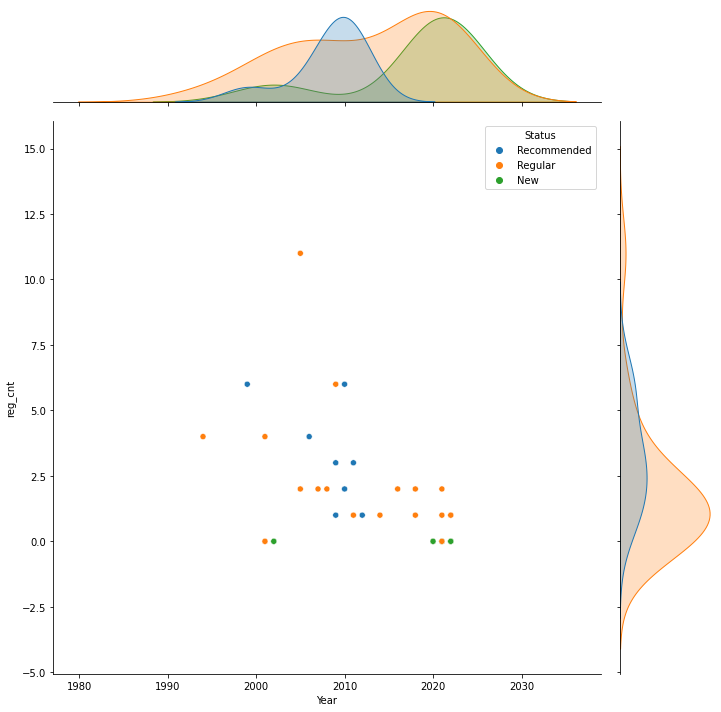

In [171]:
f = seaborn.jointplot(data=full_df, x="Year", y="reg_cnt", hue="Status", height=10)

---

#### Зависимость от размера плеча

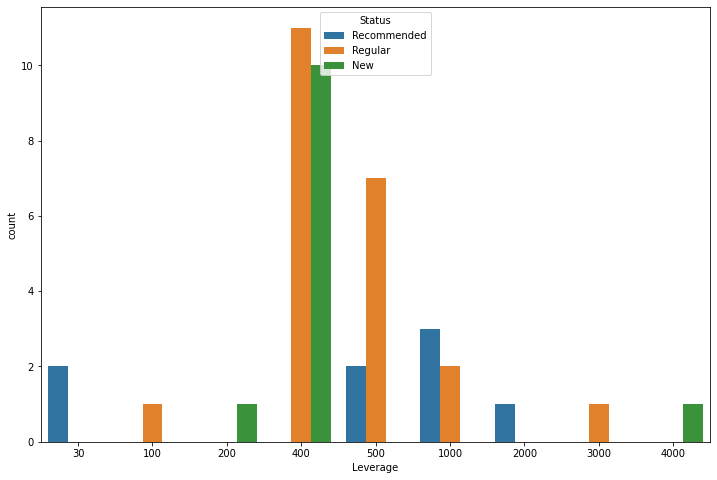

In [172]:
plt.figure(figsize=(12, 8))

seaborn.countplot(data=full_df, x='Leverage', hue='Status')
plt.show()

In [173]:
mean_rec = np.mean(full_df.Leverage.where(full_df.Status == 'Recommended'))
mean_reg = np.mean(full_df.Leverage.where(full_df.Status == 'Regular'))
mean_new = np.mean(full_df.Leverage.where(full_df.Status == 'New'))

print(f'Средние значения: \n Для всех: {np.mean(full_df.Leverage):.2f}, \n Для рекомендованных: {mean_rec:.2f}, \n Для обычных: {mean_reg:.2f}, \n Для новых: {mean_new:.2f}, \n')

Средние значения: 
 Для всех: 649.05, 
 Для рекомендованных: 757.50, 
 Для обычных: 590.91, 
 Для новых: 683.33, 



Видно, что новые и обычные (не новые и не рекомендуемые) брокеры распределены примерно нормально. 

Можно предположить, что и рекомендованные распределены нормально (их генеральная совокупность), но выборка такова, что есть заметный выброс в Leverage=0.

Кроме того, средние значения для всех трех классов довольно близки относительно размаха значений.

---
---

### Почему вообще одни брокеры находятся в верхней части списка, а другие - в нижней?

**Размышления:**

Самая явная зависимость наблюдается с возрастом брокера и размером account'а. Кроме того, нужно отметить, что список ранжирован по голосам пользователей.

(Графики 1-4) Я бы сделала такой вывод: люди чаще пользуются и меньше разочарованы теми брокерами, которые достаточно долго обитают на рынке, чтобы заработать репутацию, но не слишком долго, чтобы потерять гибкость, и теми, минимальный/средний account которых остается достаточно доступным.

(График 5) Ещё, конечно, важно, чтобы у брокера было достаточно лицензий (регуляций) - это, на мой взгляд, делает его более надежным в глазах пользователей и, вероятно, на практике тоже.



In [174]:
full_df.head()

,Broker,For,Against,Type,Regulation,Leverage,Account,Advisors,Year,Status,reg_cnt
0,FXTM,95%,5%,"Broker, ECN","CySEC, FCA, IFSC",1000,100,"Flex, 1000pip Climber",2011,Recommended,3
1,OctaFX,94%,6%,Broker,SVG,500,50,"WallStreet Evolution 2.0, Learn2Trade",2011,Regular,1
2,XM,93%,7%,Broker,"ASIC, CySEC, FSC",1000,5,"FX Classic Trader, Odin Forex Robot",2009,Recommended,3
3,FXCC,92%,8%,"ECN, STP","CySEC, SVG",500,1,"Forex Truck, Forex Fury",2010,Recommended,2
4,FxPro,91%,9%,"Broker, NDD","CySEC, FCA, FSCA, SCB",500,100,"Forex Gump, Earth Robot",2006,Recommended,4


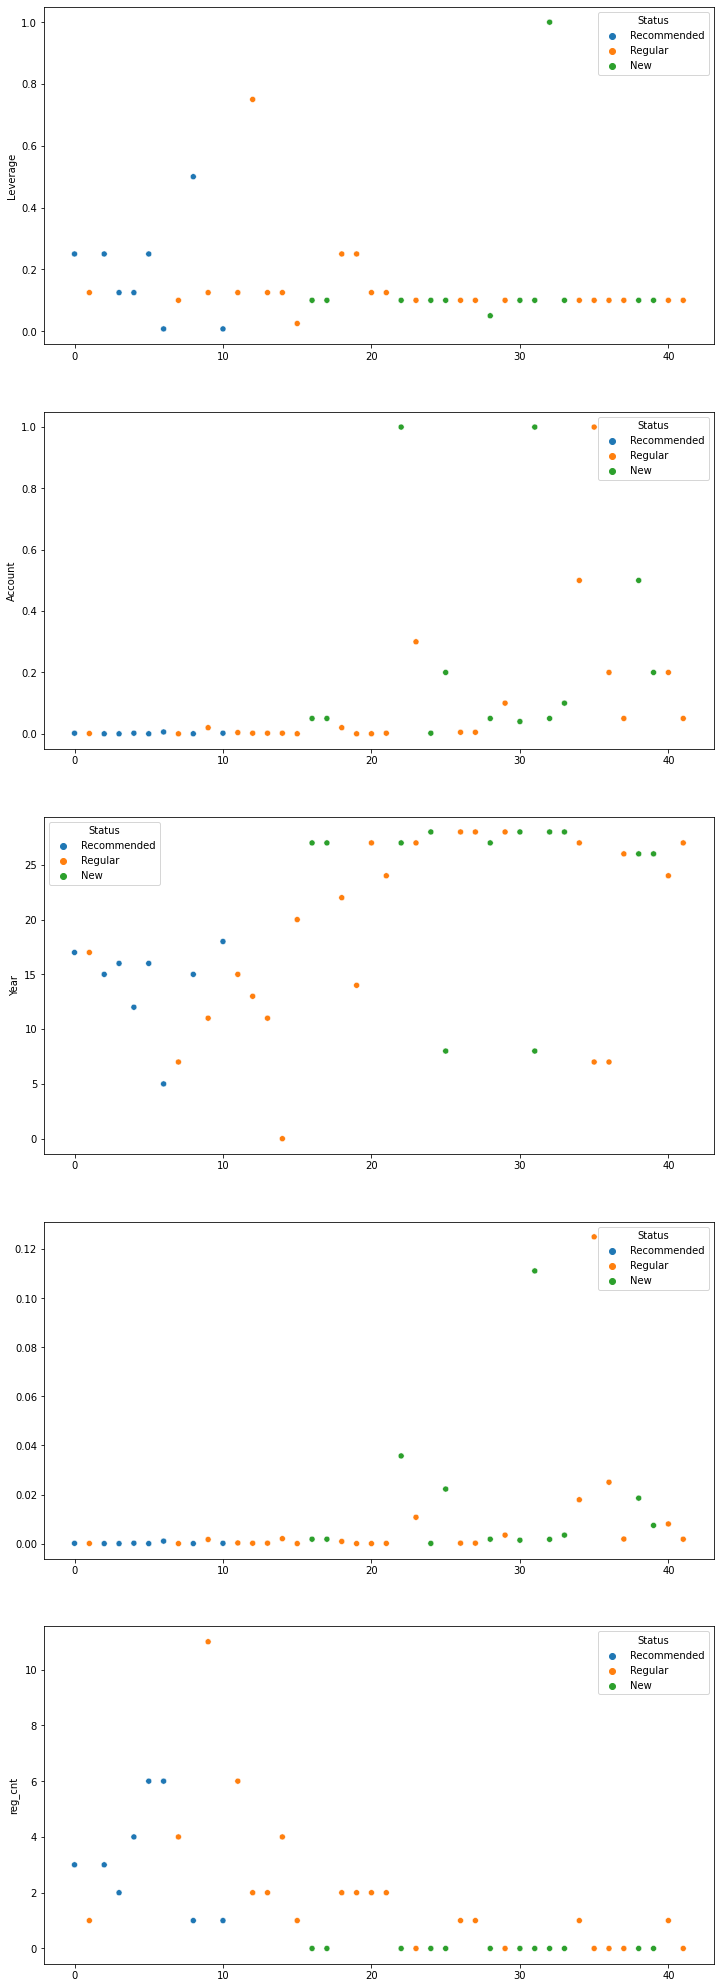

In [176]:
plt.figure(figsize=(12, 36))

plt.subplot((511))
seaborn.scatterplot(data=full_df, x=full_df.index, y=full_df.Leverage/max(full_df.Leverage), hue='Status')

plt.subplot((512))
seaborn.scatterplot(data=full_df, x=full_df.index, y=full_df.Account/max(full_df.Account), hue='Status')

plt.subplot((513))
seaborn.scatterplot(data=full_df, x=full_df.index, y=(full_df.Year - min(full_df.Year)), hue='Status')

plt.subplot((514))
seaborn.scatterplot(data=full_df, x=full_df.index, y=(full_df.Account/max(full_df.Account))/(full_df.Year - min(full_df.Year) + 1), hue='Status')

plt.subplot((515))
seaborn.scatterplot(data=full_df, x=full_df.index, y='reg_cnt', hue='Status')